# SPEED workflow: Training on the simulation data

Dataset: The simulated dataset ([here](https://doi.org/10.5281/zenodo.14948507))

In [1]:
import torch

print("Whether GPU is detected:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

Whether GPU is detected: True
CUDA version: 11.7


In [2]:
import os
import sys
adata_input_path = 'simulation/strip_pseudospot_truth_dropout_filter.h5ad'
pretrain_input_path = 'simulation/peak_ref.h5ad'
adata_output_path = './simulation_out'

In [3]:
import SPEED
import scanpy as sc

## load the data

Load the spatial epigenomic data and the corresponding single-cell data. 

Make sure their peak sets **have an overlap**, and make sure that the single-cell data has already been trained in stage 1. The trained single-cell peak embeddings should be stored in `adata_sc.varm[peak_name]`

In [4]:
adata = sc.read(adata_input_path)
adata_peak = sc.read(pretrain_input_path)

Only considering the two last: ['.2_input1_cosine_lr1e-05_batch16384_32768_fcluster0_05_ds05', '.h5ad'].
Only considering the two last: ['.2_input1_cosine_lr1e-05_batch16384_32768_fcluster0_05_ds05', '.h5ad'].


Process spatial and single-cell epigenomics data by selecting common features.

In [5]:
adata,adata_sc = SPEED.process(adata,adata_peak)

In [6]:
adata_sc

View of AnnData object with n_obs × n_vars = 133140 × 29003
    obs: 'Sample', 'Clusters', 'val'
    var: 'val'
    obsm: 'cell_embedding'
    varm: 'peak_embedding'

## Initialize the SPEED model

Initialize the model with spatial data and pre-trained single-cell data. 

`is_spatial` is set to `True` during the second stage of training on spatial data. (`is_spatial = False` indicates stage 1 training, while `is_spatial = True` indicates stage 2 training)

`k_degree` is the degree of spatial neighbor used for spatial relative position encoding. For data with a 50 μm resolution, k is defaulted to 5. For data with a 20 μm resolution, k is recommanded to 12.

If there is no paired H&E staining image, set `image` to None.

In [7]:
speed = SPEED.SPEED(adata,image=None,k_degree=5, is_spatial=True, adata_sc=adata_sc,peak_name='peak_embedding')

matrix ready...
use 0-1 matrix...
cell_features ready...
peak features ready...


### Spliting training and validation sets.

`num_workers` is the number of subprocesses for data loading (default = 4).

`data_type` sets the input data format used by SPEED. SPEED will handle this format internally, so no external action is required from the user. For lower GPU memory and faster training, it is recommended to set `dense = False` (default) when training on GPU, and `dense = True` when training on CPU.

`batch_size_cell` and `batch_size_peak` are the batch sizes at the cell-level and peak-level. SPEED will choose automatically according to dataset size, but if the batch size is too large for your GPU, you can reduce it manually.

`split_ratio` sets the proportion of the validation set at both the cell level and peak level. (default = [1/6, 1/6])

In [8]:
speed.setup_data(num_workers=4)

batch_size_cell = 32, batch_size_peak = 4096
split ready...
labels ready...
peak embedding is given
dataset ready...


### Build the neural network model for SPEED.

`emb_features` is the number of embedding features (default = 32).

`dropout_p` is the dropout probability of the model. For spatial data training, `dropout_p` is recommended to 0.4.

In [9]:
speed.build_model(emb_features=32, dropout_p=0.4)

## Train the SPEED model

`lr` is the learning rate. `device` specifies whether to train with GPU or CPU.

`epoch_num` is the maximum number of training epochs (default = 500). If no improvement is observed on the validation set within `epo_max` epochs, training is considered converged and will stop (default `epo_max=30`).

`alpha` represents the weight of the constraint on the similarity between peak embeddings of spatial data. The default value is 10. A larger `alpha` means the model relies more on single-cell prior information. 

`beta` represents the importance of image information for spot embedding. The default value is 1. A larger `beta` means the model relies more on image information.

In [10]:
speed.train(device='cuda',save=False)

Use spatial information...
Starting training...
trainset:  (334, 29003) (24170, 400)


  0%|          | 0/11 [00:00<?, ?it/s]/home/wangshuyan/workspace/project/SPEED/upload/environment/SPEED/SPEED/utils.py:104: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return torch.sparse_csr_tensor(temp.indptr,temp.indices, temp.data, size=temp.shape)
100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[1/500], Loss: 3.98229, Val Loss: 2.55456, 


100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


Epoch[2/500], Loss: 3.64662, Val Loss: 2.28905, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[3/500], Loss: 3.42653, Val Loss: 2.13255, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[4/500], Loss: 3.24524, Val Loss: 2.04066, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[5/500], Loss: 3.09712, Val Loss: 1.93174, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[6/500], Loss: 2.96608, Val Loss: 1.85860, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[7/500], Loss: 2.85359, Val Loss: 1.79467, 


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch[8/500], Loss: 2.75372, Val Loss: 1.75309, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[9/500], Loss: 2.66593, Val Loss: 1.71310, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[10/500], Loss: 2.58803, Val Loss: 1.67896, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[11/500], Loss: 2.51448, Val Loss: 1.64935, 


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch[12/500], Loss: 2.45127, Val Loss: 1.60891, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[13/500], Loss: 2.39143, Val Loss: 1.59935, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[14/500], Loss: 2.33771, Val Loss: 1.55526, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[15/500], Loss: 2.28743, Val Loss: 1.55805, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[16/500], Loss: 2.24095, Val Loss: 1.52413, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[17/500], Loss: 2.19751, Val Loss: 1.52787, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[18/500], Loss: 2.15650, Val Loss: 1.50113, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[19/500], Loss: 2.11963, Val Loss: 1.48201, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[20/500], Loss: 2.08406, Val Loss: 1.48337, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[21/500], Loss: 2.05115, Val Loss: 1.46028, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[22/500], Loss: 2.01977, Val Loss: 1.44605, 


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch[23/500], Loss: 1.99243, Val Loss: 1.43854, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[24/500], Loss: 1.96468, Val Loss: 1.44160, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[25/500], Loss: 1.94185, Val Loss: 1.44230, 


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch[26/500], Loss: 1.91710, Val Loss: 1.42578, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[27/500], Loss: 1.89410, Val Loss: 1.42579, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[28/500], Loss: 1.87436, Val Loss: 1.41969, 


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch[29/500], Loss: 1.85700, Val Loss: 1.39857, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[30/500], Loss: 1.83760, Val Loss: 1.41838, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[31/500], Loss: 1.81961, Val Loss: 1.39288, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[32/500], Loss: 1.80468, Val Loss: 1.39054, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[33/500], Loss: 1.79121, Val Loss: 1.39458, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[34/500], Loss: 1.77335, Val Loss: 1.37567, 


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch[35/500], Loss: 1.76104, Val Loss: 1.37250, 


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch[36/500], Loss: 1.74949, Val Loss: 1.38179, 


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Epoch[37/500], Loss: 1.73504, Val Loss: 1.36735, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[38/500], Loss: 1.72342, Val Loss: 1.36389, 


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch[39/500], Loss: 1.71163, Val Loss: 1.35938, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[40/500], Loss: 1.69943, Val Loss: 1.35369, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[41/500], Loss: 1.69009, Val Loss: 1.35846, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[42/500], Loss: 1.67797, Val Loss: 1.37034, 


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch[43/500], Loss: 1.66787, Val Loss: 1.35953, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[44/500], Loss: 1.65809, Val Loss: 1.34305, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[45/500], Loss: 1.64954, Val Loss: 1.34747, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[46/500], Loss: 1.64110, Val Loss: 1.35208, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[47/500], Loss: 1.63214, Val Loss: 1.34592, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[48/500], Loss: 1.62321, Val Loss: 1.35103, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[49/500], Loss: 1.61445, Val Loss: 1.34812, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[50/500], Loss: 1.60639, Val Loss: 1.34711, 


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch[51/500], Loss: 1.59915, Val Loss: 1.33228, 


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Epoch[52/500], Loss: 1.59176, Val Loss: 1.34010, 


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch[53/500], Loss: 1.58457, Val Loss: 1.31478, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[54/500], Loss: 1.57808, Val Loss: 1.33450, 


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch[55/500], Loss: 1.57158, Val Loss: 1.32955, 


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch[56/500], Loss: 1.56571, Val Loss: 1.33730, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[57/500], Loss: 1.55709, Val Loss: 1.32366, 


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch[58/500], Loss: 1.55234, Val Loss: 1.33146, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[59/500], Loss: 1.54441, Val Loss: 1.33828, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[60/500], Loss: 1.53850, Val Loss: 1.31890, 


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch[61/500], Loss: 1.53417, Val Loss: 1.31251, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[62/500], Loss: 1.52788, Val Loss: 1.32678, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[63/500], Loss: 1.52181, Val Loss: 1.31432, 


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch[64/500], Loss: 1.51698, Val Loss: 1.31483, 


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch[65/500], Loss: 1.51065, Val Loss: 1.30988, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[66/500], Loss: 1.50413, Val Loss: 1.30725, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[67/500], Loss: 1.49889, Val Loss: 1.30730, 


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch[68/500], Loss: 1.49476, Val Loss: 1.32798, 


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch[69/500], Loss: 1.49087, Val Loss: 1.30943, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[70/500], Loss: 1.48407, Val Loss: 1.32615, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[71/500], Loss: 1.47871, Val Loss: 1.30590, 


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch[72/500], Loss: 1.47351, Val Loss: 1.31645, 


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch[73/500], Loss: 1.46864, Val Loss: 1.31021, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[74/500], Loss: 1.46503, Val Loss: 1.31447, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[75/500], Loss: 1.45966, Val Loss: 1.31740, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[76/500], Loss: 1.45441, Val Loss: 1.30549, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[77/500], Loss: 1.45111, Val Loss: 1.31789, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[78/500], Loss: 1.44414, Val Loss: 1.29215, 


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch[79/500], Loss: 1.44053, Val Loss: 1.29879, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[80/500], Loss: 1.43654, Val Loss: 1.31243, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[81/500], Loss: 1.43259, Val Loss: 1.30821, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[82/500], Loss: 1.42732, Val Loss: 1.29644, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[83/500], Loss: 1.42467, Val Loss: 1.30496, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[84/500], Loss: 1.41909, Val Loss: 1.29934, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[85/500], Loss: 1.41517, Val Loss: 1.29647, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[86/500], Loss: 1.41291, Val Loss: 1.29420, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[87/500], Loss: 1.40773, Val Loss: 1.29685, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[88/500], Loss: 1.40552, Val Loss: 1.29179, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[89/500], Loss: 1.40141, Val Loss: 1.30185, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[90/500], Loss: 1.39743, Val Loss: 1.29619, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[91/500], Loss: 1.39273, Val Loss: 1.29461, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[92/500], Loss: 1.38836, Val Loss: 1.29829, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[93/500], Loss: 1.38619, Val Loss: 1.30358, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[94/500], Loss: 1.38389, Val Loss: 1.29531, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[95/500], Loss: 1.38001, Val Loss: 1.29718, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[96/500], Loss: 1.37751, Val Loss: 1.30025, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[97/500], Loss: 1.37369, Val Loss: 1.27689, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[98/500], Loss: 1.36979, Val Loss: 1.28578, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[99/500], Loss: 1.36901, Val Loss: 1.29618, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[100/500], Loss: 1.36432, Val Loss: 1.27605, 


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch[101/500], Loss: 1.36170, Val Loss: 1.29108, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[102/500], Loss: 1.35915, Val Loss: 1.30269, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[103/500], Loss: 1.35619, Val Loss: 1.30101, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[104/500], Loss: 1.35544, Val Loss: 1.29199, 


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch[105/500], Loss: 1.35237, Val Loss: 1.28847, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[106/500], Loss: 1.34833, Val Loss: 1.28155, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[107/500], Loss: 1.34666, Val Loss: 1.28005, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[108/500], Loss: 1.34381, Val Loss: 1.29599, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[109/500], Loss: 1.34348, Val Loss: 1.27326, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[110/500], Loss: 1.34098, Val Loss: 1.29810, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[111/500], Loss: 1.33722, Val Loss: 1.28152, 


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch[112/500], Loss: 1.33571, Val Loss: 1.29117, 


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch[113/500], Loss: 1.33382, Val Loss: 1.27710, 


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch[114/500], Loss: 1.33067, Val Loss: 1.27955, 


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch[115/500], Loss: 1.32950, Val Loss: 1.28420, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[116/500], Loss: 1.32662, Val Loss: 1.27821, 


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch[117/500], Loss: 1.32411, Val Loss: 1.28017, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[118/500], Loss: 1.32408, Val Loss: 1.28184, 


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch[119/500], Loss: 1.32106, Val Loss: 1.26570, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[120/500], Loss: 1.32001, Val Loss: 1.28031, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[121/500], Loss: 1.31872, Val Loss: 1.27988, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[122/500], Loss: 1.31613, Val Loss: 1.27903, 


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch[123/500], Loss: 1.31704, Val Loss: 1.28155, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[124/500], Loss: 1.31361, Val Loss: 1.28410, 


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch[125/500], Loss: 1.31287, Val Loss: 1.28300, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[126/500], Loss: 1.31020, Val Loss: 1.27960, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[127/500], Loss: 1.30889, Val Loss: 1.27939, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[128/500], Loss: 1.30768, Val Loss: 1.26998, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[129/500], Loss: 1.30645, Val Loss: 1.27331, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[130/500], Loss: 1.30497, Val Loss: 1.27626, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[131/500], Loss: 1.30541, Val Loss: 1.28064, 


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch[132/500], Loss: 1.30376, Val Loss: 1.28020, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[133/500], Loss: 1.30355, Val Loss: 1.28095, 


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch[134/500], Loss: 1.30102, Val Loss: 1.26380, 


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch[135/500], Loss: 1.29918, Val Loss: 1.28440, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[136/500], Loss: 1.29911, Val Loss: 1.26556, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[137/500], Loss: 1.29761, Val Loss: 1.27538, 


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch[138/500], Loss: 1.29530, Val Loss: 1.26500, 


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch[139/500], Loss: 1.29691, Val Loss: 1.27767, 


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch[140/500], Loss: 1.29251, Val Loss: 1.27365, 


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch[141/500], Loss: 1.29237, Val Loss: 1.27644, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[142/500], Loss: 1.29099, Val Loss: 1.26989, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[143/500], Loss: 1.29082, Val Loss: 1.26341, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[144/500], Loss: 1.28960, Val Loss: 1.25989, 


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch[145/500], Loss: 1.28891, Val Loss: 1.26772, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[146/500], Loss: 1.28732, Val Loss: 1.27975, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[147/500], Loss: 1.28682, Val Loss: 1.27089, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[148/500], Loss: 1.28570, Val Loss: 1.26610, 


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch[149/500], Loss: 1.28438, Val Loss: 1.26755, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[150/500], Loss: 1.28514, Val Loss: 1.26404, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[151/500], Loss: 1.28272, Val Loss: 1.28288, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[152/500], Loss: 1.28338, Val Loss: 1.27069, 


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch[153/500], Loss: 1.28275, Val Loss: 1.26852, 


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch[154/500], Loss: 1.28038, Val Loss: 1.26615, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[155/500], Loss: 1.27898, Val Loss: 1.25793, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[156/500], Loss: 1.27818, Val Loss: 1.26898, 


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch[157/500], Loss: 1.27817, Val Loss: 1.26495, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[158/500], Loss: 1.27690, Val Loss: 1.28061, 


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch[159/500], Loss: 1.27833, Val Loss: 1.27041, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[160/500], Loss: 1.27667, Val Loss: 1.26755, 


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch[161/500], Loss: 1.27553, Val Loss: 1.25717, 


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch[162/500], Loss: 1.27386, Val Loss: 1.25664, 


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch[163/500], Loss: 1.27299, Val Loss: 1.27002, 


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch[164/500], Loss: 1.27337, Val Loss: 1.25842, 


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch[165/500], Loss: 1.27186, Val Loss: 1.26526, 


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch[166/500], Loss: 1.27244, Val Loss: 1.26963, 


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch[167/500], Loss: 1.27085, Val Loss: 1.25542, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[168/500], Loss: 1.26862, Val Loss: 1.27291, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[169/500], Loss: 1.26979, Val Loss: 1.25713, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[170/500], Loss: 1.26721, Val Loss: 1.26082, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[171/500], Loss: 1.26789, Val Loss: 1.25771, 


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch[172/500], Loss: 1.26708, Val Loss: 1.24934, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[173/500], Loss: 1.26754, Val Loss: 1.26380, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[174/500], Loss: 1.26582, Val Loss: 1.26448, 


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch[175/500], Loss: 1.26505, Val Loss: 1.27786, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[176/500], Loss: 1.26524, Val Loss: 1.25934, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[177/500], Loss: 1.26211, Val Loss: 1.25759, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[178/500], Loss: 1.26346, Val Loss: 1.26491, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[179/500], Loss: 1.26152, Val Loss: 1.26545, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[180/500], Loss: 1.26217, Val Loss: 1.25158, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[181/500], Loss: 1.26179, Val Loss: 1.27078, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[182/500], Loss: 1.26104, Val Loss: 1.26123, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[183/500], Loss: 1.26062, Val Loss: 1.26112, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[184/500], Loss: 1.25915, Val Loss: 1.26674, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[185/500], Loss: 1.25956, Val Loss: 1.26323, 


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch[186/500], Loss: 1.25714, Val Loss: 1.26200, 


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch[187/500], Loss: 1.25777, Val Loss: 1.25108, 


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch[188/500], Loss: 1.25701, Val Loss: 1.25947, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[189/500], Loss: 1.25792, Val Loss: 1.27297, 


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch[190/500], Loss: 1.25518, Val Loss: 1.26555, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[191/500], Loss: 1.25472, Val Loss: 1.26717, 


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch[192/500], Loss: 1.25303, Val Loss: 1.26015, 


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch[193/500], Loss: 1.25186, Val Loss: 1.27111, 


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch[194/500], Loss: 1.25286, Val Loss: 1.27908, 


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch[195/500], Loss: 1.25214, Val Loss: 1.25599, 


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch[196/500], Loss: 1.25109, Val Loss: 1.25738, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[197/500], Loss: 1.25203, Val Loss: 1.27183, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch[198/500], Loss: 1.25043, Val Loss: 1.25511, 


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch[199/500], Loss: 1.25080, Val Loss: 1.26700, 


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch[200/500], Loss: 1.24991, Val Loss: 1.26282, 


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch[201/500], Loss: 1.24851, Val Loss: 1.27088, 


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

Epoch[202/500], Loss: 1.24819, Val Loss: 1.25236, 
convinient


In [11]:
torch.save(speed.model.state_dict(), f'simulation_out/model.pth')

## Get the results

Use `SPEED.SPEED.get_embedding` to get the low-dimensional embedding.

The spot/cell embeddings will be stored in `adata.obsm['X_SPEED']`. The peak embeddings will be stored in `adata.varm['peak_SPEED']`

In [12]:
adata = speed.get_embedding(adata)

get cell/spot embedding...


100%|██████████| 5/5 [00:00<00:00, 36.99it/s]


get peak embedding...


100%|██████████| 5/5 [00:00<00:00, 417.06it/s]


get spatial embedding...


100%|██████████| 5/5 [00:00<00:00, 1169.83it/s]

(81, 400)
(81, 400)
(81, 400)
(81, 400)
(76, 400)
the shape of embedding: (400, 32)


Use `SPEED.SPEED.get_denoise_result` to get the denoised matrix.

In [13]:
adata.X = speed.get_denoise_result()

In [14]:
sc.pp.neighbors(adata, use_rep='X_SPEED', random_state=1)
sc.tl.umap(adata)
sc.tl.leiden(adata, random_state=1, key_added="leiden_spot",resolution=0.2)

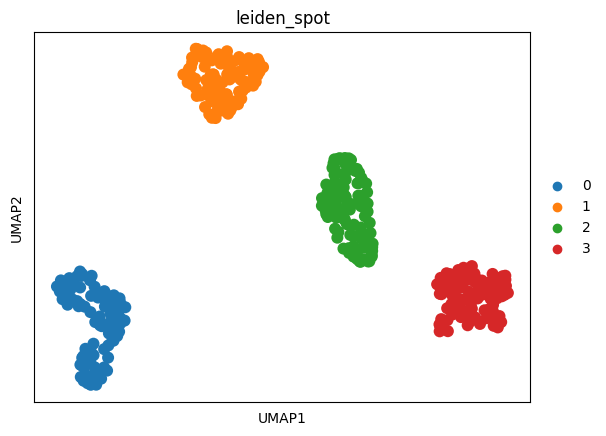

In [15]:
sc.pl.umap(adata,color='leiden_spot')

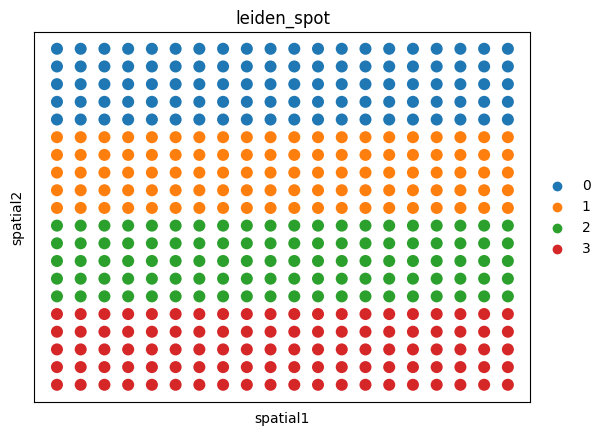

In [16]:
sc.pl.embedding(adata,basis='spatial',color='leiden_spot')

In [17]:
plot = ['chr16:29893731-29894231','chr4:42860430-42860930','chr4:53797048-53797548','chr6:16727179-16727679']

Use `SPEED.binarize` to binarize the denoised matrix.

In [19]:
adata = speed.binarize(adata)

100%|██████████| 29003/29003 [00:02<00:00, 12033.06it/s]


In [20]:
adata.write(f'simulation_out/adata_speed.h5ad')

In [21]:
adata.X=adata.obsm['binary_SPEED']